In [22]:
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.pipeline import make_pipeline

# About the model

Logistic regression is a fundamental classification technique. It uses a logistic function to transform the linear regression output into a probability score, which can be interpreted as the likelihood of belonging to a particular class. For this problem, we have categorical features such as the party of the governor and of the chambers. These columns will be onee hot encoded. We also have text data as well. For this, we will need to use Count Vectorizer and Tfidf Vectorizer in order to plug them into the Logistic model.

CountVectorizer is a feature extraction technique used in natural language processing to convert text documents into numerical representations. It creates a matrix where each row corresponds to a document, and each column represents the frequency of a specific word in that document. TF-IDF Vectorizer stands for Term Frequency-Inverse Document Frequency Vectorizer. It is another feature extraction method used in NLP that assigns weights to each word in a document based on its frequency within the document and its rarity across all documents. The resulting matrix reflects the importance of each word in a document relative to the entire corpus. Both of these techniques are used in order to extract information through our modeling.

As our target variable is very imbalanced, oversampling techniques will be used to help our model recognize the unbalanced class. The most notable method we will use is SMOTE, (Synthetic Minority Over-sampling Technique). SMOTE creates synthetic samples of the minority class by interpolating new instances between existing minority class samples, effectively balancing the dataset and improving the performance of classification models on the minority class.

During our modeling, we are trying to optimize for the metric of recall. this is because a bill rarely passes, and it would be helpful for those who use our model to know wether a bill is more likely to pass.

Below is a summary of our results on the test data with our best results in bold.

|Model|accuracy|recall|precision|
|---|---|---|---|
|cv_logit|0.828602|0.349817|0.646362
|cv_lemma_logit|0.830094|0.342857|0.659387
|cv_stem_logit|0.827595|0.319414|0.658113
|tfidif_logit|0.834757|0.298168|0.731357
|cv_SMOTE_logit|0.752247|0.634982|0.427181
|cv_OverSample_logit|0.746988|0.649084|0.421353
|**tfidf_SMOTE_logit**|**0.747920**|**0.658425**|**0.423539**

The model in bold has lower accuracy than the baseline model. This is okay though because we are trying to optimize for recall. This model can identify 66% of the bills that pass from the test data. When it does think it is a passed bill, it is correct 42% of the time. These may not be the best results, and this could be due to the lack of information in some titles. For example, the bill titled 'An Act establishing the Jonesville Public Use Area.' may not be very useful to our model. This is not enough info to predict whether it will pass or not. in the next notebook, Random Forest are used to predict bill outcome based off of their titles and results are slightly better there. 

We also tested models on different text data such as the bills subjects and abstracts. Although these are outside the scope of the problem statement, they show promise to improve on our model in future studies.

|Model|accuracy|recall|precision|
|---|---|---|---|
|subjects_SMOTE|0.728441|0.643970|0.395400
|abstracts_SMOTE|0.782182|0.714592|0.521739

These are impressive results as the recall is quite high and the accuracy is very close to the baseline. The precision is also quite high. This is very promissing for further research.

No inference was done for this model because the performance is too poor to have any valuable inference from it.

# Read In Data

In [23]:
df = pd.read_csv('../../Data/Merged_Data/final_data.csv.zip')
df_with_sponsors = pd.read_csv('../../Data/Merged_Data/final_data_with_sponsors.csv.zip')

# Splitting Data into Train and Test 

In [24]:
X = df[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

In [25]:
df['law_enacted'].value_counts(normalize=True)

0    0.796322
1    0.203678
Name: law_enacted, dtype: float64

# Metrics Function

In [26]:
def my_metrics(estimator, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    
    train_preds = estimator.predict(X_train)
    preds = estimator.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_preds)
    train_recall = recall_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    
    print(f'Train Accuracy: {train_acc}')
    print(f'Train Recall: {train_recall}')
    print(f'Test Accuracy: {test_acc}')
    print(f'Test Recall: {recall}')
    print(f'Test Precision: {precision}')
    print()
    print(f'Test Confusion Matrix:')
    
    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    
    return {
        'accuracy': test_acc,
        'recall': recall,
        'precision': precision
    }

In [27]:
#List that will keep track of metrics
history = []

In [28]:
#For column transformers later
word_feature = 'title'
party_features = ['gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']

# Baseline Model

This model is one that guesses that the bill will not pass for every bill.

In [29]:
df['law_enacted'].value_counts(normalize = True)

0    0.796322
1    0.203678
Name: law_enacted, dtype: float64

This model has 79.6% accuracy

# Simple CV with Logit
**Strategy:**
First model will be kept simple:

    -CountVectorize title
    -OneHotEncode categorical variables
    -Logistic Regression

In [30]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe = Pipeline([
    ('pre', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_pipe.fit(X_train, y_train);

Train Accuracy: 0.8667313239828907
Train Recall: 0.43526036261522494
Test Accuracy: 0.8286023350367414
Test Recall: 0.3498168498168498
Test Precision: 0.6463620981387479

Test Confusion Matrix:


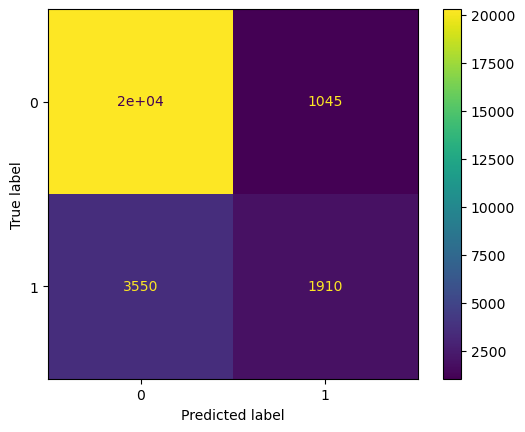

In [31]:
history.append(my_metrics(logit_pipe))

The test accuracy for this model is 82.8% accuracy, better than our base model but not by too much. It seems to slighly over fit as the training accuracy is 3% higher. Our recall and precision are not veery impressive.

# Lemmatize title CV with Logit
**Strategy:**
Second model will be kept simple:

    -WordNetLemmatize titles before word count vectorizing
    -CountVectorize title
    -OneHotEncode categorical variables
    -Logistic Regression
    
Lemmatizing is the act of bring words down to their base. So a word like cats becomes cat.

In [32]:
#Making column for the Title lemmatized
wnl = WordNetLemmatizer()
df['lemma_title'] = df['title'].map(lambda x:' '.join([wnl.lemmatize(word) for word in word_tokenize(x)]))

word_feature = 'lemma_title'

In [33]:
#Have to resplit as we are using a new colum. Same random state makes it the same sample for the train and test
X = df[['lemma_title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

In [34]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_lemma = Pipeline([
    ('pre', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_pipe_lemma.fit(X_train, y_train);

Train Accuracy: 0.8655749527504227
Train Recall: 0.427263292839265
Test Accuracy: 0.8300943712932224
Test Recall: 0.34285714285714286
Test Precision: 0.6593871081366678

Test Confusion Matrix:


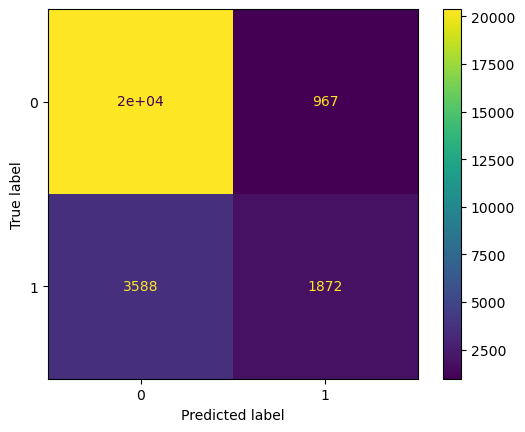

In [35]:
history.append(my_metrics(logit_pipe_lemma,X_train, X_test, y_train, y_test))

In [36]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387


Lemmatizing did not improve the model significantly. Although, the precision improved and the rcall became worse.

# Porter Stem title CV with Logit
**Strategy:**
Second model will be kept simple:

    -Porter Stemming titles before word count vectorizing
    -CountVectorize title
    -OneHotEncode categorical variables
    -Logistic Regression
    
Stemming is like lemmatizing but more extreme. Words like computational or compute or computes become comput.

In [37]:
#Making column for the Titles stemmed
ps = PorterStemmer()
df['stemmed_title'] = df['title'].map(lambda x:' '.join([ps.stem(word) for word in word_tokenize(x)]))

word_feature = 'stemmed_title'

In [38]:
#Have to resplit as we are using a new colum. Same random state makes it the same sample for the train and test
X = df[['stemmed_title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

In [39]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_stemmed = Pipeline([
    ('pre', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_pipe_stemmed.fit(X_train, y_train);

Train Accuracy: 0.8564980602805132
Train Recall: 0.3833709785727367
Test Accuracy: 0.8275952105636167
Test Recall: 0.3194139194139194
Test Precision: 0.6581132075471698

Test Confusion Matrix:


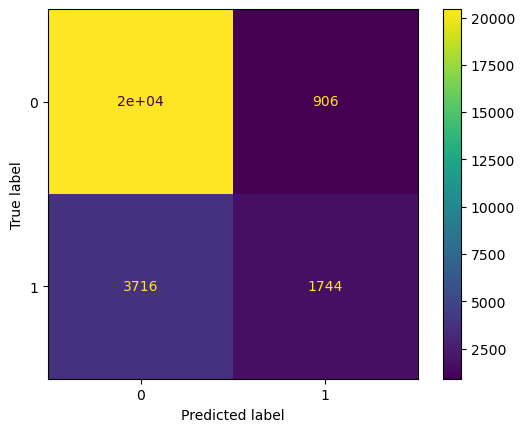

In [40]:
history.append(my_metrics(logit_pipe_stemmed,X_train, X_test, y_train, y_test))

In [41]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113


Stemming did not help the model.

# TFIDF with Logit
**Strategy:**
Second model will be kept simple:

    -TFIDF title
    -OneHotEncode categorical variables
    -Logistic Regression
    
Stemming is like lemmatizing but more extreme. Words like computational or compute or computes become comput.

In [42]:
X = df[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

word_feature = 'title'

Train Accuracy: 0.846165323783945
Train Recall: 0.3229351077467798
Test Accuracy: 0.8347569845947257
Test Recall: 0.29816849816849816
Test Precision: 0.7313566936208445

Test Confusion Matrix:


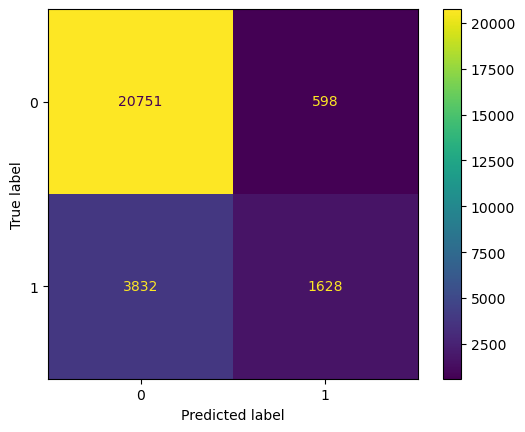

In [43]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('tfidf', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_tfidf = Pipeline([
    ('pre', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_pipe_tfidf.fit(X_train, y_train)

history.append(my_metrics(logit_pipe_tfidf,X_train, X_test, y_train, y_test));

In [44]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit', 'tfidif_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113
tfidif_logit,0.834757,0.298168,0.731357


Worst recall but best accuracy. Also pretty high prcision. The recall is just so darn low.

# CV with Logit and SMOTE oversampling
**Strategy:**
Second model will be kept simple:

    -Cvec title
    -OneHotEncode categorical variables
    -SMOTE oversampling
    -Logistic Regression
    
SMOTE: Synthetic Minority Over-sampling Technique (SMOTE)

Train Accuracy: 0.8223415895752512
Train Recall: 0.78694829375496
Test Accuracy: 0.7522473796113246
Test Recall: 0.634981684981685
Test Precision: 0.427180877279448

Test Confusion Matrix:


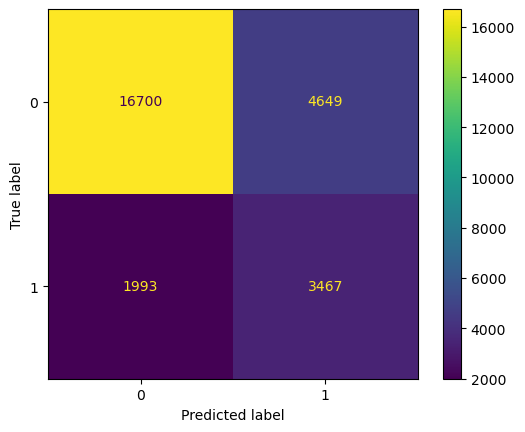

In [45]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_smote = make_pipeline(preprocess, SMOTE(random_state = 42), LogisticRegression(max_iter=1000))

logit_pipe_smote.fit(X_train, y_train)

history.append(my_metrics(logit_pipe_smote,X_train, X_test, y_train, y_test));

In [46]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit', 'tfidif_logit', 'cv_SMOTE_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113
tfidif_logit,0.834757,0.298168,0.731357
cv_SMOTE_logit,0.752247,0.634982,0.427181


Worst accuracy yet, but not significantly worse compared to the increase in recall! Although the accuracy is loweer than the baseline, I would say this is the beest model yet.

# CV with Logit and random oversampling
**Strategy:**
Second model will be kept simple:

    -Cvec title
    -OneHotEncode categorical variables
    -Random oversampling
    -Logistic Regression
    

Train Accuracy: 0.8219188301999403
Train Recall: 0.8263231792930834
Test Accuracy: 0.7469879518072289
Test Recall: 0.6490842490842491
Test Precision: 0.42135299013197003

Test Confusion Matrix:


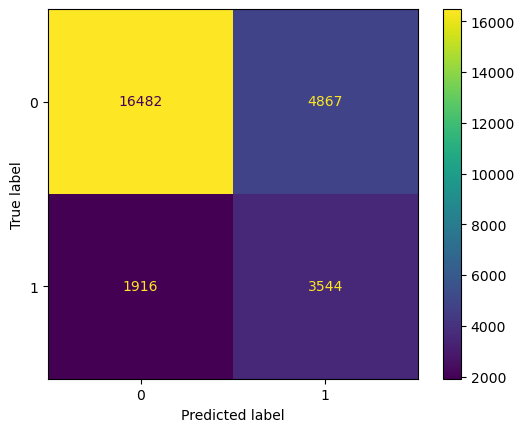

In [47]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_ROS = make_pipeline(preprocess, RandomOverSampler(random_state = 42), LogisticRegression(max_iter=1000))

logit_pipe_ROS.fit(X_train, y_train)

history.append(my_metrics(logit_pipe_ROS,X_train, X_test, y_train, y_test));

In [48]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit', 'tfidif_logit', 'cv_SMOTE_logit', 'cv_OverSample_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113
tfidif_logit,0.834757,0.298168,0.731357
cv_SMOTE_logit,0.752247,0.634982,0.427181
cv_OverSample_logit,0.746988,0.649084,0.421353


# TFIDF with Logit and random oversampling
**Strategy:**
Second model will be kept simple:

    -TFIDF title
    -OneHotEncode categorical variables
    -Random oversampling
    -Logistic Regression
    

Train Accuracy: 0.7994752810106436
Train Recall: 0.7775471582931445
Test Accuracy: 0.7479204744675295
Test Recall: 0.6584249084249084
Test Precision: 0.4235391140433553

Test Confusion Matrix:


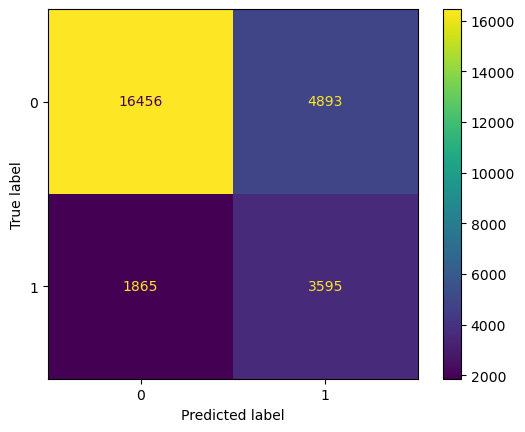

In [49]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_tfidf_smote = make_pipeline(preprocess, SMOTE(random_state = 42), LogisticRegression(max_iter=1000))

logit_pipe_tfidf_smote.fit(X_train, y_train)

history.append(my_metrics(logit_pipe_tfidf_smote,X_train, X_test, y_train, y_test));

In [50]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit', 'tfidif_logit', 'cv_SMOTE_logit', 'cv_OverSample_logit', 'tfidf_SMOTE_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113
tfidif_logit,0.834757,0.298168,0.731357
cv_SMOTE_logit,0.752247,0.634982,0.427181
cv_OverSample_logit,0.746988,0.649084,0.421353
tfidf_SMOTE_logit,0.747920,0.658425,0.423539


This is the best model for Logistic. 65% of the passed bills were recognized. When we predicted it would pass, we were right 42% of the time. Although the accuracy is lower than the baseline, the goal was to maximize recall.

# Word vectorizer on other text items

although our problem statement is based on the titles of bills, I want to study if other text data would be helpful as well. We have two columns that could be interesting. Firstly, the subject feature. This feature has a list of subjects that the bill pertains to. The thing is, we have a lot less data with subject lists. The abstracts feature could be interesting as well. This feature holds a summary of each bill which holds more info than the title and the subjects. the issue with the abstracts feature is that we have even less data on that one.

These two models are just to show the possibility of further study using these text data instead of the title for bill prediction.

## Word Vectorizer on Subjects

In [51]:
other_text=[]

In [52]:
subjects_df = df[df['subject'].isnull() == False]

In [53]:
X = subjects_df[['subject', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = subjects_df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

word_feature = 'subject'
party_features = ['gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']

In [54]:
subjects_df['law_enacted'].value_counts(normalize=True)

0    0.797436
1    0.202564
Name: law_enacted, dtype: float64

Train Accuracy: 0.7820508086551954
Train Recall: 0.7947502734232592
Test Accuracy: 0.7284408751038494
Test Recall: 0.6439704675963905
Test Precision: 0.39539959704499666

Test Confusion Matrix:


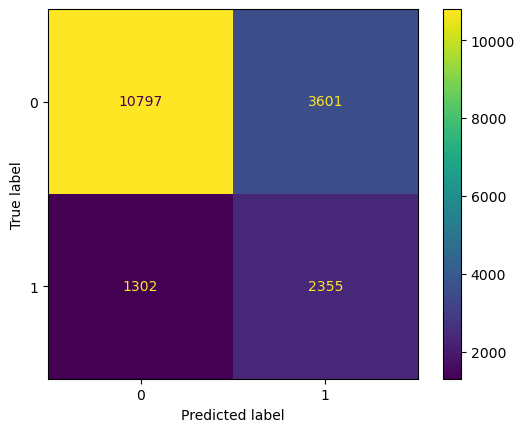

In [55]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('tfid', TfidfVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_subjects = make_pipeline(preprocess, SMOTE(random_state = 42), LogisticRegression(max_iter=1000))

logit_pipe_subjects.fit(X_train, y_train)

other_text.append(my_metrics(logit_pipe_subjects,X_train, X_test, y_train, y_test));

Not significantly different from our title data.

## Word Vectorizer on abstracts

In [56]:
abstracts_df = df[df['abstract'].isnull() == False]

In [57]:
X = abstracts_df[['abstract', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = abstracts_df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

word_feature = 'abstract'
party_features = ['gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']

In [58]:
abstracts_df['law_enacted'].value_counts(normalize=True)

0    0.768437
1    0.231563
Name: law_enacted, dtype: float64

Train Accuracy: 0.8380001656863557
Train Recall: 0.8402504472271914
Test Accuracy: 0.7821819085487077
Test Recall: 0.7145922746781116
Test Precision: 0.5217391304347826

Test Confusion Matrix:


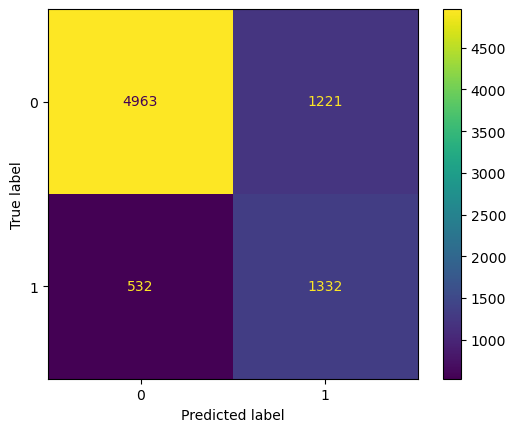

In [59]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('tfid', TfidfVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_abstracts = make_pipeline(preprocess, SMOTE(random_state = 42), LogisticRegression(max_iter=1000))

logit_pipe_abstracts.fit(X_train, y_train)

other_text.append(my_metrics(logit_pipe_abstracts,X_train, X_test, y_train, y_test));

Great model. Has the best recall and decent accuracy as well. This shows much promise to be a good feature for bill prediction. It is not in the scope of this problem statemnet but good to keep in mind.

In [60]:
pd.DataFrame(other_text, index = ['subjects', 'abstracts'])

,accuracy,recall,precision
subjects,0.728441,0.643970,0.395400
abstracts,0.782182,0.714592,0.521739
